# **Modeling**

# 1.1.Importing Dependancies

In [1]:
!pip install xgboost bayesian-optimization onnxmltools fastapi uvicorn onnxruntime


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.0/329.0 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
ERROR: pip's dependency resolver does not currently

In [2]:
# Import necessary libraries (only once)
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# 1.2.Loading Data

In [3]:
# load the indices data
data_path = "final.csv"
df = pd.read_csv(data_path)
print(df.shape)
df.head(3)

(517, 10)


,Region,Year,mean_ndvi,mean_bsi,mean_ndwi,Area_Name,Final_Label,Area_Trend,Risk_Factor,Area_Risk_Trend
0,19,2019.0,-0.398018,1.776907,-0.605452,Segera,0,Overall Stable,2.780377,Stable
1,19,2020.0,0.206553,1.005695,-0.846624,Segera,0,Overall Stable,2.058872,Stable
2,19,2021.0,-0.403002,1.666466,-0.524266,Segera,0,Overall Stable,2.593735,Stable


In [4]:
# Load the rainfall data
rain = pd.read_csv("rain.csv")
print(rain.shape)
rain.head(3)


(826, 3)


,Protected_Area_Name,Year,Mean_Rainfall_mm
0,Aberdare,2019,23.086656
1,Aberdare,2020,29.291239
2,Aberdare,2021,17.633956


In [5]:
# prepare the two dfs for merging
rain = rain.rename(columns={'Protected_Area_Name': 'Area_Name'})

# Convert 'Year' to datetime format
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
rain['Year'] = pd.to_datetime(rain['Year'], format='%Y')


In [6]:
# merge all into one dataframe
df = df.merge(rain[['Area_Name', 'Year', 'Mean_Rainfall_mm']], on=['Area_Name', 'Year'], how='left')
print(df.shape)
df.head(3)

(517, 11)


,Region,Year,mean_ndvi,mean_bsi,mean_ndwi,Area_Name,Final_Label,Area_Trend,Risk_Factor,Area_Risk_Trend,Mean_Rainfall_mm
0,19,2019-01-01,-0.398018,1.776907,-0.605452,Segera,0,Overall Stable,2.780377,Stable,13.133455
1,19,2020-01-01,0.206553,1.005695,-0.846624,Segera,0,Overall Stable,2.058872,Stable,14.671010
2,19,2021-01-01,-0.403002,1.666466,-0.524266,Segera,0,Overall Stable,2.593735,Stable,8.738780


# 1.3.Data Understanding

In [7]:
# random sample of the data
df.sample(10)

,Region,Year,mean_ndvi,mean_bsi,mean_ndwi,Area_Name,Final_Label,Area_Trend,Risk_Factor,Area_Risk_Trend,Mean_Rainfall_mm
449,26,2021-01-01,1.590491,-0.762492,-1.339827,Namunyak Wildlife Conservation Trust,2,Overall Gain,3.692811,High Risk Gain,5.633971
279,52,2025-01-01,-1.205033,-0.899242,2.370318,Lemek,1,Overall Loss,4.474593,Severe Risk Loss,17.535578
98,14,2019-01-01,2.576852,-2.181524,-2.293673,Kalama Community Wildlife Conservancy,2,Overall Gain,7.052048,High Risk Gain,11.904983
310,46,2022-01-01,0.407361,-0.763334,-0.153175,Makurian (Oreteti),2,Overall Stable,1.323870,Stable,7.394413
370,35,2019-01-01,2.718789,-2.429702,-2.417143,Ol Lentille Conservancy,2,Overall Gain,7.565634,High Risk Gain,12.589560
376,35,2025-01-01,0.871361,-1.684435,-0.467011,Ol Lentille Conservancy,2,Overall Gain,3.022806,High Risk Gain,3.505519
65,11,2021-01-01,2.403083,-1.815829,-2.042289,Sera Community Conservancy,2,Overall Gain,6.261201,High Risk Gain,4.547228
49,15,2019-01-01,1.643420,-0.645607,-1.417438,Nailepu,2,Overall Gain,3.706465,High Risk Gain,9.043786
155,73,2020-01-01,1.268889,-0.113632,-1.225732,Chyulu Hills,2,Overall Stable,2.608254,Stable,13.250511
109,9,2023-01-01,-0.767695,0.764716,0.425329,Hanshak-Nyongoro Community Conservancy,1,Overall Loss,1.957741,Severe Risk Loss,17.646312


In [8]:
# shape
df.shape

(517, 11)

In [9]:
# data types
df.dtypes

,0
Region,int64
Year,datetime64[ns]
mean_ndvi,float64
mean_bsi,float64
mean_ndwi,float64
Area_Name,object
Final_Label,int64
Area_Trend,object
Risk_Factor,float64
Area_Risk_Trend,object


In [10]:
# features
df.columns

Index(['Region', 'Year', 'mean_ndvi', 'mean_bsi', 'mean_ndwi', 'Area_Name',
       'Final_Label', 'Area_Trend', 'Risk_Factor', 'Area_Risk_Trend',
       'Mean_Rainfall_mm'],
      dtype='object')

In [11]:
# descriptive statistics
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Region,517.0,36.485493,0.0,18.0,36.0,55.0,73.0,21.398813
Year,517,2021-12-29 17:41:11.953578240,2019-01-01 00:00:00,2020-01-01 00:00:00,2022-01-01 00:00:00,2024-01-01 00:00:00,2025-01-01 00:00:00,NaN
mean_ndvi,517.0,0.0,-2.462436,-0.729203,-0.210559,0.572992,3.045923,1.000969
mean_bsi,517.0,0.0,-3.001384,-0.643079,0.105723,0.75178,1.951511,1.000969
mean_ndwi,517.0,-0.0,-2.630251,-0.552864,0.060278,0.597147,4.009605,1.000969
Final_Label,517.0,1.03675,0.0,1.0,1.0,2.0,2.0,0.710254
Risk_Factor,517.0,2.351146,0.177558,1.50069,2.05642,2.679362,8.576017,1.508197
Mean_Rainfall_mm,510.0,10.97356,0.370056,7.254547,10.399865,13.791971,33.667218,5.359742


# 1.4.Data Cleaning

**Missing Values**

In [12]:
# check for missing values
df.isnull().sum()

,0
Region,0
Year,0
mean_ndvi,0
mean_bsi,0
mean_ndwi,0
Area_Name,7
Final_Label,0
Area_Trend,7
Risk_Factor,0
Area_Risk_Trend,0


In [13]:
# drop rows with null values
df.dropna(inplace=True)

**Duplicates**

In [14]:
# check for duplicates
df.duplicated().sum()

0

**Check for Constant and Quasiconstant features**

In [15]:
df.nunique()

,0
Region,73
Year,7
mean_ndvi,510
mean_bsi,510
mean_ndwi,510
Area_Name,73
Final_Label,3
Area_Trend,3
Risk_Factor,510
Area_Risk_Trend,5


**rearrange features**

In [16]:
df= df[['Region', 'Area_Name', 'Year', 'mean_ndvi', 'mean_bsi', 'mean_ndwi', 'Mean_Rainfall_mm','Risk_Factor',
       'Final_Label', 'Area_Trend', 'Area_Risk_Trend']]
df.sample(3)

,Region,Area_Name,Year,mean_ndvi,mean_bsi,mean_ndwi,Mean_Rainfall_mm,Risk_Factor,Final_Label,Area_Trend,Area_Risk_Trend
48,16,Ngare Ndare Community Conservancy,2025-01-01,0.449566,-0.765297,-0.325494,6.378746,1.540358,2,Overall Gain,High Risk Gain
457,33,Ol Jogi Ranch,2022-01-01,-1.141993,0.824317,0.824348,7.515118,2.790658,1,Overall Loss,Severe Risk Loss
235,63,Mount Kenya National Park/Natural Forest,2023-01-01,-1.239953,0.330553,0.886806,26.908540,2.457312,1,Overall Loss,Severe Risk Loss


# 1.5.Exploratory Data Analysis

In [17]:
# convert year to integer for better plotting
df['Year'] = pd.to_datetime(df['Year'])

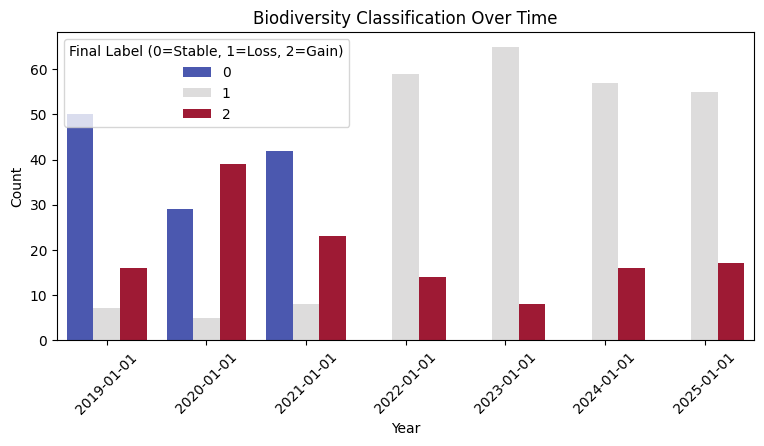

In [18]:
# Plot biodiversity classification trend over time
plt.figure(figsize=(9, 4))
sns.countplot(data=df, x="Year", hue="Final_Label", palette="coolwarm")
plt.title("Biodiversity Classification Over Time")
plt.xlabel("Year")
plt.ylabel("Count")
plt.legend(title="Final Label (0=Stable, 1=Loss, 2=Gain)")
plt.xticks(rotation=45)
plt.show()

**Observation:**


---


Most locations in recent years have experienced biodiversity stability, with few having biodiversity loss and a statistically insignificant number having gain.
However, up untill 2021 there was a significant number of areas experiencing biodiversity gain.

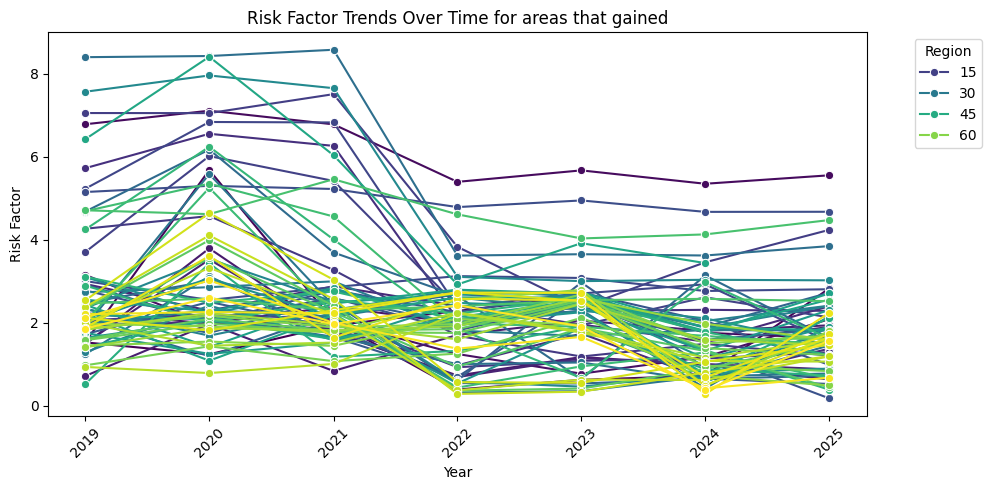

In [19]:
# Plot Risk Factor trend over time
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x="Year", y="Risk_Factor", hue="Region", marker="o", palette="viridis")
plt.title("Risk Factor Trends Over Time for areas that gained")
plt.xlabel("Year")
plt.ylabel("Risk Factor")
plt.legend(title="Region", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Observation:**


---
The gain and loss risk factors were high from 2019 and highest in 2021 after which majority of the protected areas have been stable in terms of gain or loss of biodeiversity.


In [20]:
# Identify Top High Risk Gain and Severe Risk Loss Areas
top5_high_risk_gain = df[df["Area_Risk_Trend"] == "High Risk Gain"].nlargest(5, "Risk_Factor")
top5_severe_risk_loss = df[df["Area_Risk_Trend"] == "Severe Risk Loss"].nlargest(5, "Risk_Factor")

<ipython-input-21-9b12985b88df>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top5_high_risk_gain, x="Area_Name", y="Risk_Factor", palette="Reds")


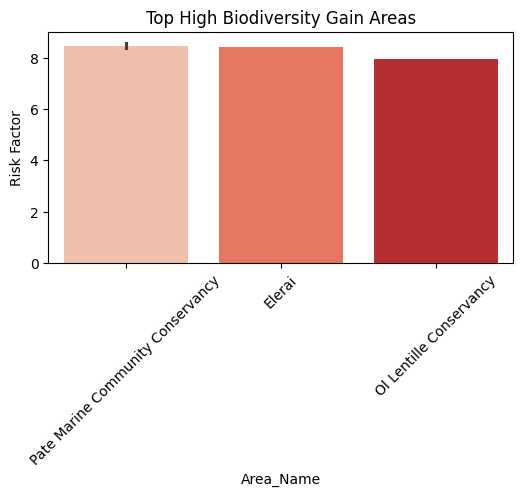

In [21]:
# Plot Top High Risk Gain Areas
plt.figure(figsize=(6, 3))
sns.barplot(data=top5_high_risk_gain, x="Area_Name", y="Risk_Factor", palette="Reds")
plt.title("Top High Biodiversity Gain Areas")
plt.ylabel("Risk Factor")
plt.xticks(rotation=45)
plt.show()

**Observation:**


---


Pate Marine Community Conservancy has experienced the most gain in biodiversity followed by Elerai and Ol Lentile Conservancy

<ipython-input-22-d6b547ed98ef>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top5_severe_risk_loss, x="Area_Name", y="Risk_Factor", palette="Blues")


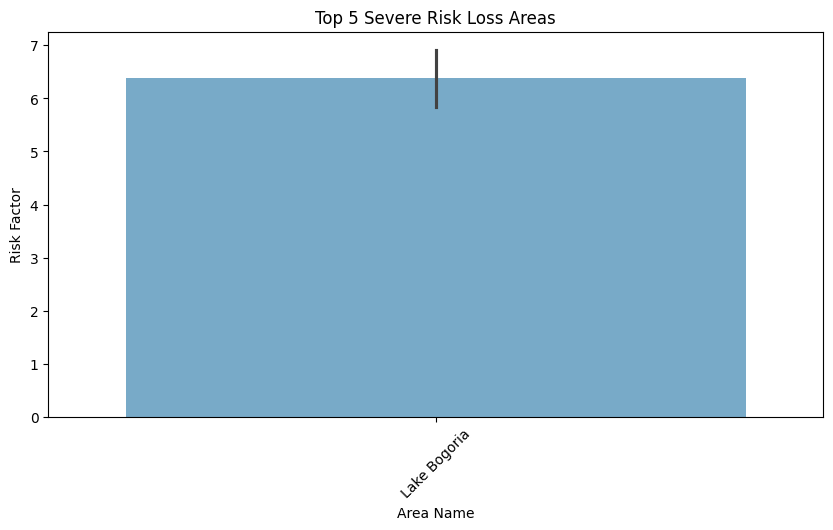

In [22]:
# Plot Top Severe Risk Loss Areas
plt.figure(figsize=(10, 5))
sns.barplot(data=top5_severe_risk_loss, x="Area_Name", y="Risk_Factor", palette="Blues")
plt.title("Top 5 Severe Risk Loss Areas")
plt.xlabel("Area Name")
plt.ylabel("Risk Factor")
plt.xticks(rotation=45)
plt.show()


**Observation:**


---


Lake Bongoria has experienced by far the most loss in biodiversity.

In [23]:
# Select a few regions to visualize
selected_regions = df["Region"].unique()[:5]  # First 5 unique regions
df_selected = df[df["Region"].isin(selected_regions)]


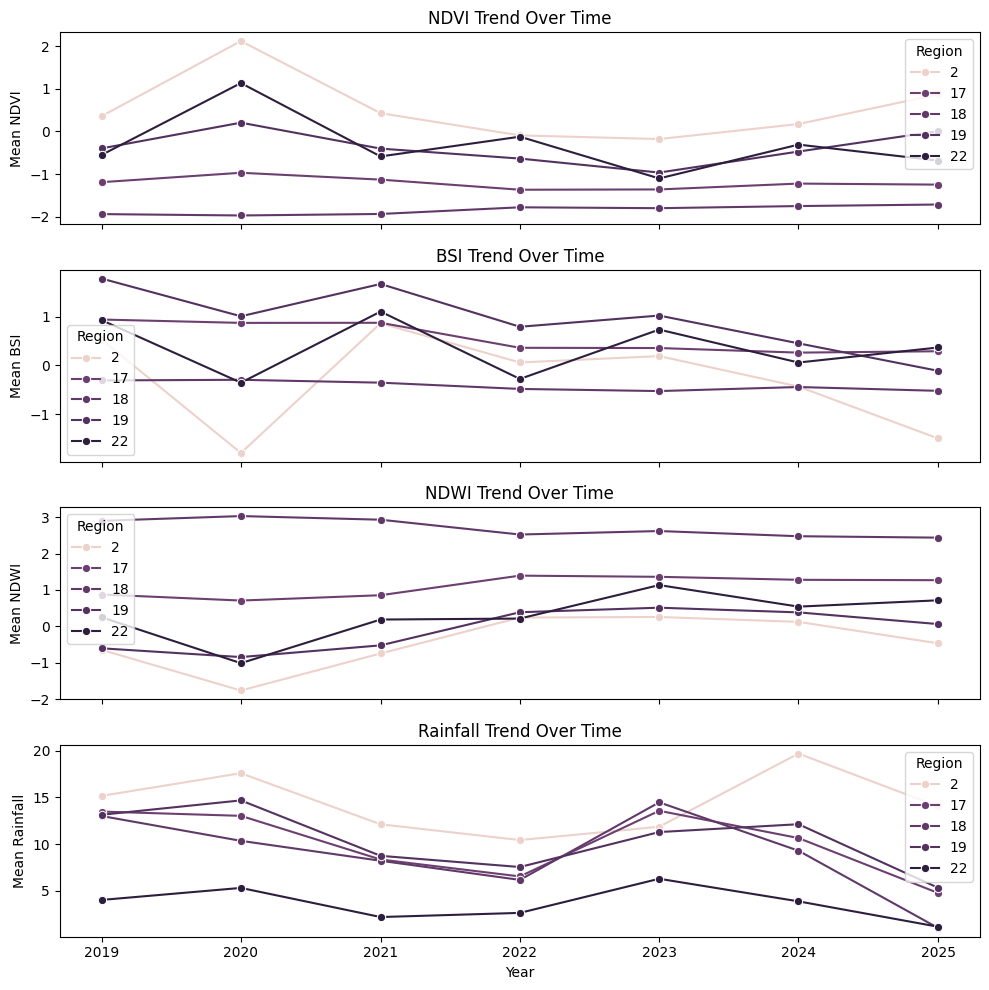

In [24]:
# Set up the plot
fig, axes = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

# NDVI Trend
sns.lineplot(data=df_selected, x="Year", y="mean_ndvi", hue="Region", marker="o", ax=axes[0])
axes[0].set_title("NDVI Trend Over Time")
axes[0].set_ylabel("Mean NDVI")

# BSI Trend
sns.lineplot(data=df_selected, x="Year", y="mean_bsi", hue="Region", marker="o", ax=axes[1])
axes[1].set_title("BSI Trend Over Time")
axes[1].set_ylabel("Mean BSI")

# NDWI Trend
sns.lineplot(data=df_selected, x="Year", y="mean_ndwi", hue="Region", marker="o", ax=axes[2])
axes[2].set_title("NDWI Trend Over Time")
axes[2].set_ylabel("Mean NDWI")

# Rainfall Trend
sns.lineplot(data=df_selected, x="Year", y="Mean_Rainfall_mm", hue="Region", marker="o", ax=axes[3])
axes[3].set_title("Rainfall Trend Over Time")
axes[3].set_ylabel("Mean Rainfall")

plt.xlabel("Year")
plt.tight_layout()
plt.show()


**Observation:**


---



*   NDVI(Normalized Difference Vegetation Index): Measures the 'greenness' of vegetation.
*   NDWI(Normalized Difference Water Index): Highlights water bodies and their moisture content
*   BSI (Bare Soil Index): Identifies areas of bare soil.
*   Rainfall Index: Measures aggregare rainfall over a given period of time.


---

High NDVI, NDWI and Rainfall means health in terms of vegetation and water bodies that is good for the ecosystem. It is clear that biodiversity was fairly good up untill 2021 when NDVI,NDWI and rainfall were relatively high and BSI was low. However, the indices seem to have nudged in the opposite direction in recent years hence biodiversity has been mostly stable with minimal loss.





# 1.6.Feature Engineering

In [25]:
# create lagged variables for NDVI, NDWI, BSI, Risk Factor, Rainfall
lag_features = ['mean_ndvi', 'mean_ndwi', 'mean_bsi', 'Risk_Factor', 'Mean_Rainfall_mm']
for lag in range(1, 4):
    for feature in lag_features:
        df[f'{feature}_lag_{lag}'] = df.groupby('Area_Name')[feature].shift(lag)

In [26]:
# drop nan values after lagging
df.dropna(inplace=True)

In [27]:
df.columns

Index(['Region', 'Area_Name', 'Year', 'mean_ndvi', 'mean_bsi', 'mean_ndwi',
       'Mean_Rainfall_mm', 'Risk_Factor', 'Final_Label', 'Area_Trend',
       'Area_Risk_Trend', 'mean_ndvi_lag_1', 'mean_ndwi_lag_1',
       'mean_bsi_lag_1', 'Risk_Factor_lag_1', 'Mean_Rainfall_mm_lag_1',
       'mean_ndvi_lag_2', 'mean_ndwi_lag_2', 'mean_bsi_lag_2',
       'Risk_Factor_lag_2', 'Mean_Rainfall_mm_lag_2', 'mean_ndvi_lag_3',
       'mean_ndwi_lag_3', 'mean_bsi_lag_3', 'Risk_Factor_lag_3',
       'Mean_Rainfall_mm_lag_3'],
      dtype='object')

# **2.0.Modeling**

# 2.1.Data Preprocessing

In [28]:
# define features and target
features = ['mean_ndvi', 'mean_bsi', 'mean_ndwi', 'Risk_Factor','Mean_Rainfall_mm']
target = 'Area_Risk_Trend'

In [29]:
# Encode target variable
le = LabelEncoder()
df[target] = le.fit_transform(df[target])

In [30]:
# 2. Create a DataFrame for the mapping (Recommended):
label_mapping = pd.DataFrame({'Original_Class': le.classes_, 'Encoded_Label': le.transform(le.classes_)})
print("\nLabel Mapping DataFrame:")
print(label_mapping)


Label Mapping DataFrame:
       Original_Class  Encoded_Label
0      High Risk Gain              0
1  Moderate Risk Gain              1
2  Moderate Risk Loss              2
3    Severe Risk Loss              3
4              Stable              4


In [31]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

In [32]:
# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 2.2.Baseline Model - **XGBoost**

In [33]:
from bayes_opt import BayesianOptimization
import xgboost as xgb
from sklearn.metrics import accuracy_score
from onnxmltools.convert.common.data_types import FloatTensorType
import onnxmltools

# Define function to evaluate XGBoost parameters
def xgb_evaluate(n_estimators, learning_rate, max_depth, subsample, colsample_bytree):
    params = {
        'n_estimators': int(n_estimators),
        'learning_rate': learning_rate,
        'max_depth': int(max_depth),
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'random_state': 42
    }
    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return accuracy_score(y_test, preds)

# Define hyperparameter search space
xgb_bo = BayesianOptimization(
    f=xgb_evaluate,
    pbounds={
        'n_estimators': (100, 500),
        'learning_rate': (0.01, 0.2),
        'max_depth': (3, 10),
        'subsample': (0.6, 1.0),
        'colsample_bytree': (0.6, 1.0),
    },
    random_state=42
)

# Optimize hyperparameters
xgb_bo.maximize(init_points=5, n_iter=15)

# Train XGBoost with the best hyperparameters
best_params = xgb_bo.max['params']
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = int(best_params['max_depth'])

best_xgb = xgb.XGBClassifier(**best_params, random_state=42)
best_xgb.fit(X_train, y_train)

# Save as ONNX for deployment
num_features = X_train.shape[1]  # Get the number of features from the training data
initial_type = [('float_input', FloatTensorType([None, num_features]))] # Define the input type for onnx model
onnx_model = onnxmltools.convert_xgboost(best_xgb, initial_types=initial_type) #Pass the initial_types argument.
onnxmltools.utils.save_model(onnx_model, 'xgb_model.onnx')

|   iter    |  target   | colsam... | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
| 1         | 0.7288    | 0.7498    | 0.1906    | 8.124     | 339.5     | 0.6624    |
| 2         | 0.7797    | 0.6624    | 0.02104   | 9.063     | 340.4     | 0.8832    |
| 3         | 0.7458    | 0.6082    | 0.1943    | 8.827     | 184.9     | 0.6727    |
| 4         | 0.7627    | 0.6734    | 0.06781   | 6.673     | 272.8     | 0.7165    |
| 5         | 0.7966    | 0.8447    | 0.0365    | 5.045     | 246.5     | 0.7824    |
| 6         | 0.7797    | 0.8635    | 0.02436   | 5.057     | 246.5     | 0.8074    |
| 7         | 0.7797    | 0.8106    | 0.0157    | 4.715     | 246.5     | 0.7279    |
| 8         | 0.7797    | 0.7897    | 0.02461   | 9.225     | 340.5     | 0.8673    |
| 9         | 0.7797    | 0.9469    | 0.05603   | 4.824     | 246.7     | 0.9203    |
| 10        | 0.7797    | 0.923     | 0.0434    | 5.21

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.71      0.62      0.67         8
           2       0.00      0.00      0.00         1
           3       0.75      0.94      0.83        16
           4       0.78      0.72      0.75        25

    accuracy                           0.80        59
   macro avg       0.65      0.66      0.65        59
weighted avg       0.78      0.80      0.79        59



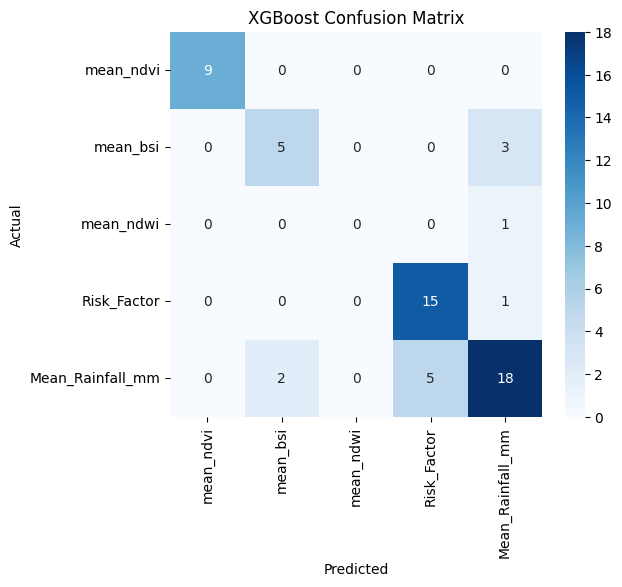

XGBoost Accuracy: 0.7966
XGBoost Precision: 0.7844
XGBoost Recall: 0.7966
XGBoost F1-score: 0.7867


In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Make predictions
xgb_preds = best_xgb.predict(X_test)

# Compute metrics
xgb_acc = accuracy_score(y_test, xgb_preds)
xgb_precision = precision_score(y_test, xgb_preds, average="weighted")
xgb_recall = recall_score(y_test, xgb_preds, average="weighted")
xgb_f1 = f1_score(y_test, xgb_preds, average="weighted")

# Print classification report
print("XGBoost Classification Report:\n", classification_report(y_test, xgb_preds))

# Get the class labels (replace with your actual labels if different)
class_labels = sorted(list(set(y_test)))

# Confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, xgb_preds), annot=True, cmap="Blues", fmt="d",xticklabels=features,  # Add x-axis labels
            yticklabels=features)  # Add y-axis labels
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("XGBoost Confusion Matrix")
plt.show()

# Print metrics
print(f"XGBoost Accuracy: {xgb_acc:.4f}")
print(f"XGBoost Precision: {xgb_precision:.4f}")
print(f"XGBoost Recall: {xgb_recall:.4f}")
print(f"XGBoost F1-score: {xgb_f1:.4f}")


## Model Interpretability - Optics and Shap

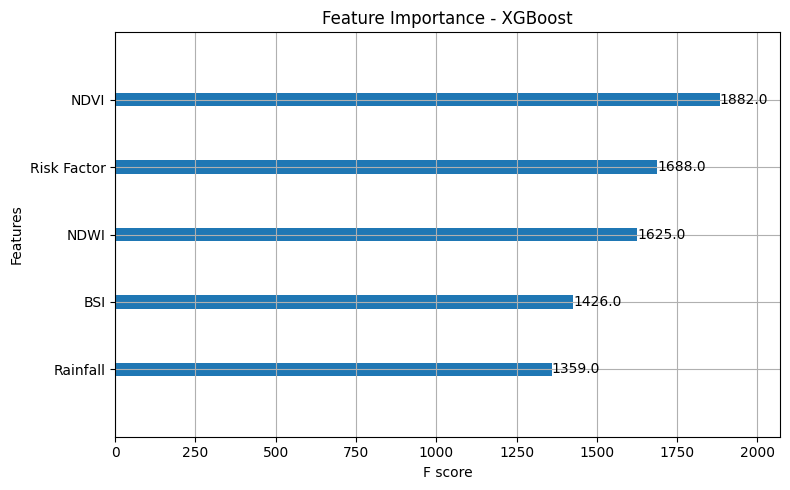

In [35]:
# visualize feature importance
fig, ax = plt.subplots(figsize=(8, 5))
xgb.plot_importance(best_xgb, ax=ax)
plt.title("Feature Importance - XGBoost")

ax.set_yticklabels(['Rainfall','BSI','NDWI','Risk Factor','NDVI']) # Set the y-axis labels explicitly (important!)

plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()
plt.show()

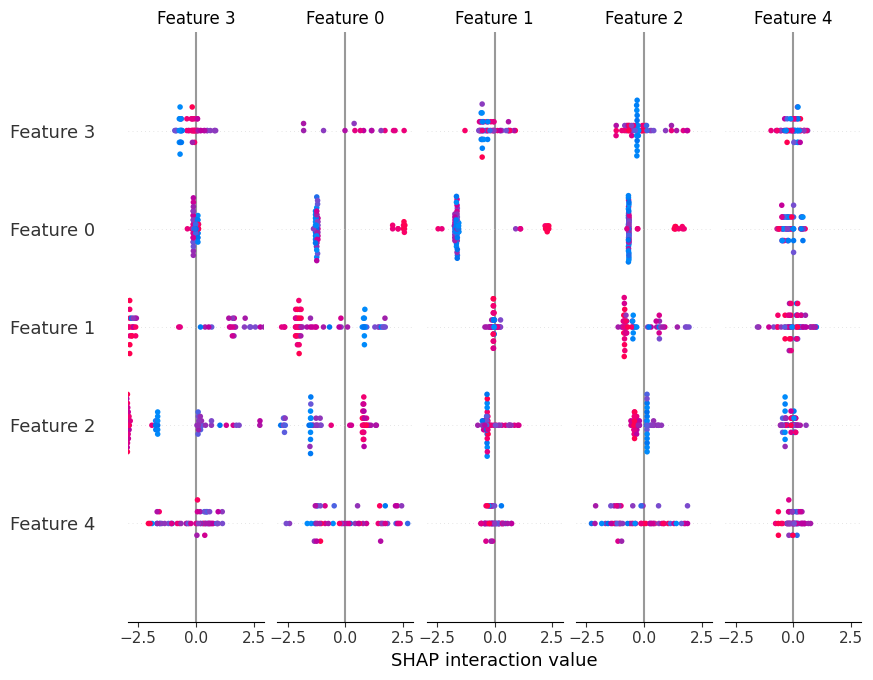

In [36]:
# Initialize SHAP explainer
explainer = shap.Explainer(best_xgb)  # Assuming best_xgb is your trained XGBoost model
shap_values = explainer(X_test)

# Summary plot (Global Feature Importance)
shap.summary_plot(shap_values, X_test)


**Interpretation:**


---


In the visual, the more spread a feature has the more important it is to the model.**ndvi and risk factor influence greatest**


---





# 2.3.Deep Learning Model - **LSTM**

In [57]:
# Define LSTM Model
def create_lstm_model(input_shape, num_classes):
    model = keras.Sequential([
        layers.LSTM(128, return_sequences=True, input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.LSTM(64, return_sequences=False),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def create_sequences(df, target_col, sequence_length=3):
    sequences = []
    labels = []

    if len(df) < sequence_length: #Check that the sequence length is less than the dataframe length
         return np.array([]), np.array([]) #Return empty array if it isn't

    for i in range(len(df) - sequence_length + 1): #Iterate up to the last possible start of sequence
        seq = df.iloc[i:i+sequence_length][['mean_ndvi', 'mean_bsi', 'mean_ndwi', 'Risk_Factor','Mean_Rainfall_mm']].values
        label = df.iloc[i+sequence_length-1][target_col] #Get the corresponding label
        sequences.append(seq)
        labels.append(label)

    return np.array(sequences), np.array(labels)

In [65]:
# Split data
features2 = ['mean_ndvi_lag_1', 'mean_ndwi_lag_1',
       'mean_bsi_lag_1', 'Risk_Factor_lag_1', 'Mean_Rainfall_mm_lag_1',
       'mean_ndvi_lag_2', 'mean_ndwi_lag_2', 'mean_bsi_lag_2',
       'Risk_Factor_lag_2', 'Mean_Rainfall_mm_lag_2', 'mean_ndvi_lag_3',
       'mean_ndwi_lag_3', 'mean_bsi_lag_3', 'Risk_Factor_lag_3',
       'Mean_Rainfall_mm_lag_3']
X_train_df, X_test_df, y_train, y_test = train_test_split(df[features2], df[target], test_size=0.2, random_state=42)

# Convert X_train_df and X_test_df to dataframes with index
X_train_df = X_train_df.reset_index()
X_test_df = X_test_df.reset_index()
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
df['Final_Label'] = le.fit_transform(df['Area_Risk_Trend'])

In [66]:
# Apply to grouped data
grouped_train = df.iloc[X_train_df.index].groupby("Area_Name")
X_train, y_train_seq = [], []
for _, group in grouped_train:
    seq, labels = create_sequences(group, target_col="Final_Label", sequence_length=3)
    if seq.size > 0: # Check if seq has a value before appending
        X_train.append(seq)
        y_train_seq.append(labels)

X_train = np.concatenate(X_train)
y_train_seq = np.concatenate(y_train_seq)

grouped_test = df.iloc[X_test_df.index].groupby("Area_Name")
X_test_lstm, y_test_seq = [], []
for _, group in grouped_test:
    seq, labels = create_sequences(group, target_col="Final_Label", sequence_length=3)
    if seq.size > 0:
        X_test_lstm.append(seq)
        y_test_seq.append(labels)


X_test_lstm = np.concatenate(X_test_lstm)
y_test_seq = np.concatenate(y_test_seq)


In [67]:
# Initialize and train model
lstm_model = create_lstm_model((X_train.shape[1], X_train.shape[2]), len(le.classes_))
lstm_model.fit(X_train, y_train_seq, epochs=50, batch_size=32, validation_data=(X_test_lstm, y_test_seq))

# Save LSTM model for deployment
lstm_model.save("lstm_model.h5")

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 391ms/step - accuracy: 0.1459 - loss: 2.1307 - val_accuracy: 0.1724 - val_loss: 1.6151
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3426 - loss: 1.5532 - val_accuracy: 0.1034 - val_loss: 1.6057
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4333 - loss: 1.4577 - val_accuracy: 0.1724 - val_loss: 1.5903
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4350 - loss: 1.3563 - val_accuracy: 0.2069 - val_loss: 1.5751
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4809 - loss: 1.2487 - val_accuracy: 0.2414 - val_loss: 1.5583
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4427 - loss: 1.2525 - val_accuracy: 0.2414 - val_loss: 1.5405
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4906 - loss: 1.1659 - val_accuracy: 0.2759 - val_loss: 1.5252
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4806 - loss: 1.1318 - val_accuracy: 0.3793 - val_loss: 1.5082
Epoch 9/5

In [68]:
# Make predictions
lstm_preds = np.argmax(lstm_model.predict(X_test_lstm), axis=-1)

# Compute metrics
lstm_acc = accuracy_score(y_test_seq, lstm_preds) # Use y_test_seq here
lstm_precision = precision_score(y_test_seq, lstm_preds, average="weighted") # Use y_test_seq here
lstm_recall = recall_score(y_test_seq, lstm_preds, average="weighted") # Use y_test_seq here
lstm_f1 = f1_score(y_test_seq, lstm_preds, average="weighted") # Use y_test_seq here

# Print classification report
print("LSTM Classification Report:\n", classification_report(y_test_seq, lstm_preds)) # Use y_test_seq here

# Print metrics
print(f"LSTM Accuracy: {lstm_acc:.4f}")
print(f"LSTM Precision: {lstm_precision:.4f}")
print(f"LSTM Recall: {lstm_recall:.4f}")
print(f"LSTM F1-score: {lstm_f1:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 840ms/step
LSTM Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.89      0.94         9
           1       0.00      0.00      0.00         3
           3       1.00      0.89      0.94         9
           4       0.62      1.00      0.76         8

    accuracy                           0.83        29
   macro avg       0.65      0.69      0.66        29
weighted avg       0.79      0.83      0.79        29

LSTM Accuracy: 0.8276
LSTM Precision: 0.7905
LSTM Recall: 0.8276
LSTM F1-score: 0.7944


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

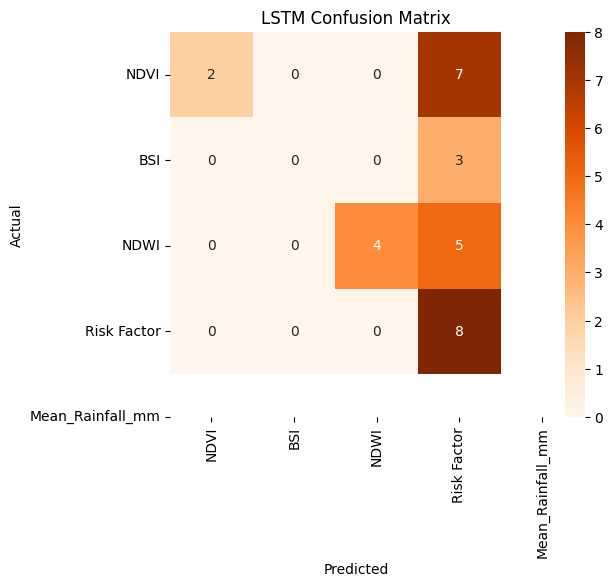

In [42]:
# LSTM confusion matrix
class_labels = ['NDVI','BSI','NDWI','Risk Factor', 'Mean_Rainfall_mm']
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test_seq, lstm_preds), annot=True, cmap="Oranges", fmt="d",xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("LSTM Confusion Matrix")
plt.show()

## Model Interpretability

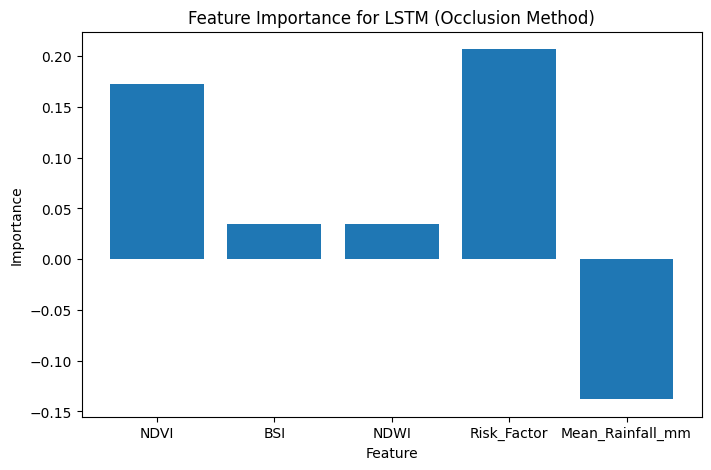

In [43]:
# function to visualize feature importance
def feature_importance_lstm(model, X_test, y_test):
    base_acc = model.evaluate(X_test, y_test, verbose=0)[1]  # Baseline accuracy
    importances = []

    for i in range(X_test.shape[2]):  # Iterate through each feature
        X_test_copy = X_test.copy()
        X_test_copy[:, :, i] = 0  # Mask feature i
        acc = model.evaluate(X_test_copy, y_test, verbose=0)[1]
        importances.append(base_acc - acc)  # Drop in accuracy when masked

    return np.array(importances)

# Compute feature importance
importances = feature_importance_lstm(lstm_model, X_test_lstm, y_test_seq)

# Plot Feature Importance
plt.figure(figsize=(8, 5))
plt.bar(range(X_test_lstm.shape[2]), importances, tick_label=['NDVI', 'BSI', 'NDWI', 'Risk_Factor','Mean_Rainfall_mm']) #Removed Rainfall
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance for LSTM (Occlusion Method)")
plt.show()

# 2.4.Compare - **XGBoost and LSTM**

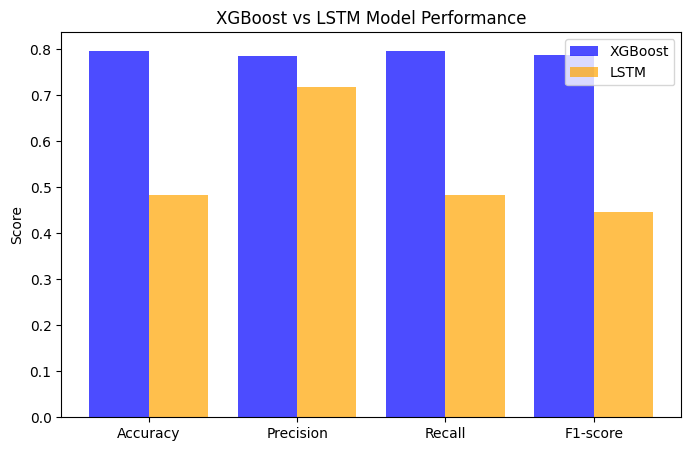

In [44]:
# Define metrics
metrics = ["Accuracy", "Precision", "Recall", "F1-score"]
xgb_scores = [xgb_acc, xgb_precision, xgb_recall, xgb_f1]  # XGBoost scores
lstm_scores = [lstm_acc, lstm_precision, lstm_recall, lstm_f1]  # LSTM scores

x = range(len(metrics))

# Create bar plot
plt.figure(figsize=(8, 5))
plt.bar(x, xgb_scores, width=0.4, label="XGBoost", color="blue", alpha=0.7)
plt.bar([i + 0.4 for i in x], lstm_scores, width=0.4, label="LSTM", color="orange", alpha=0.7)

plt.xticks([i + 0.2 for i in x], metrics)
plt.ylabel("Score")
plt.title("XGBoost vs LSTM Model Performance")
plt.legend()
plt.show()